In [180]:
# Essentials
import os
import numpy as np
import pandas as pd
from collections import Counter

# Images
from PIL import Image

# Plots
import matplotlib as mpl;
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from skimage import transform, exposure, io
from skimage.feature import hog
from skimage.transform import resize
from sklearn.decomposition import PCA


#Accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, silhouette_score , adjusted_rand_score

print("Setup Complete")

Setup Complete


### Reduction of Dataset 

In [181]:
percentage = 0.4

dataset_path = 'src/utkface/'
all_images = os.listdir(dataset_path)


bins = [0, 18, 60, 80, float('inf')]
def age_range(filename):
    age = int(filename.split('_')[0].split('/')[-1])
    
    if age < bins[1]:
        return 1
    elif age < bins[2]:
        return 2
    elif age < bins[3]:
        return 3
    else:
        return 4

ages = [age_range(filename) for filename in all_images]

unused, dataset = train_test_split(all_images, train_size=percentage, stratify=ages ,random_state=42)

## Loading Images

In [182]:
data = []

for filename in dataset:
    temp = filename.split('_')
    data_age = temp[0].split('/')[-1]
    data_gender = temp[1]
    data_race = temp[2]
    data.append([dataset_path+filename, data_age, data_gender, data_race]) 

In [183]:
df = pd.DataFrame(data, columns=["image", "age", "gender", "race"])
df.head(5)

image age gender race
0  src/utkface/76_1_0_20170110183026065.jpg.chip.jpg  76      1    0
1  src/utkface/32_1_0_20170117182511453.jpg.chip.jpg  32      1    0
2  src/utkface/32_1_4_20170105164252747.jpg.chip.jpg  32      1    4
3  src/utkface/62_1_0_20170110160643813.jpg.chip.jpg  62      1    0
4  src/utkface/45_0_4_20170117204242833.jpg.chip.jpg  45      0    4

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14226 entries, 0 to 14225
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   14226 non-null  object
 1   age     14226 non-null  object
 2   gender  14226 non-null  object
 3   race    14226 non-null  object
dtypes: object(4)
memory usage: 444.7+ KB


In [185]:
print(df.shape)
gender_dict = {0:'Male', 1:'Female'}
race_dict = {0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Others'}

(14226, 4)


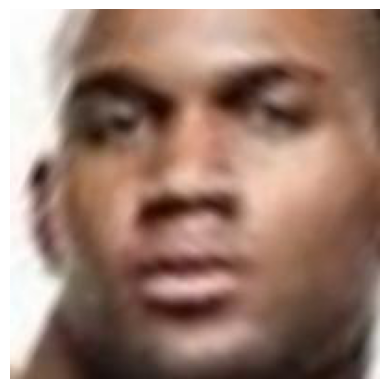

In [186]:
img = Image.open(df.sample().values[0,0])
plt.axis("off")
plt.imshow(img)

## Preprocessing

#### Handling Incomplete rows

In [187]:
df['gender'].value_counts()

0    7437
1    6788
3       1
Name: gender, dtype: int64

In [188]:
df.drop(df[df['gender'] == '3'].index, inplace=True)

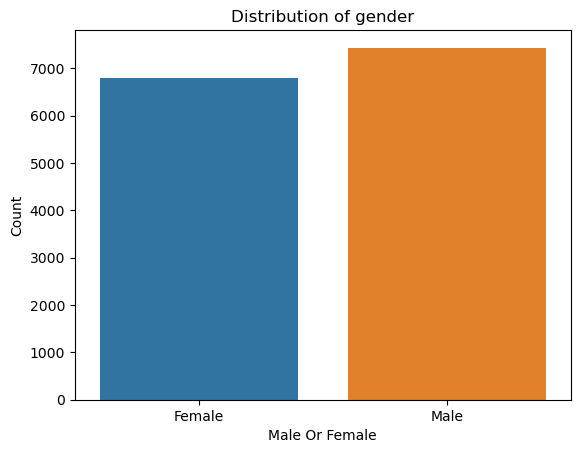

In [189]:
gender_data = [gender_dict[int(g)] for g in df['gender']]

sns.countplot(x=gender_data, data=df)
plt.title('Distribution of gender')
plt.xlabel('Male Or Female')
plt.ylabel('Count')
plt.show()

In [190]:
duplicate_rows = df[df.duplicated(subset=['image'] , keep=False)]
duplicate_rows

# there are no duplicate images

Empty DataFrame
Columns: [image, age, gender, race]
Index: []

In [191]:
df['age'].value_counts()

26     1319
1       673
35      549
28      540
24      514
       ... 
105       3
115       2
91        2
101       2
111       1
Name: age, Length: 103, dtype: int64

In [192]:
df['race'].value_counts()

0                                 5959
1                                 2765
3                                 2424
2                                 2074
4                                 1001
20170116174525125.jpg.chip.jpg       1
20170109142408075.jpg.chip.jpg       1
Name: race, dtype: int64

In [193]:
df.drop(df[~df['race'].isin(['0','1','2','3','4'])].index, inplace=True)

In [194]:
df.isnull().sum()

image     0
age       0
gender    0
race      0
dtype: int64

In [195]:
df['age'] = df['age'].astype(int)
df['gender'] = df['gender'].astype(int)
df['race'] = df['race'].astype(int)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14223 entries, 0 to 14225
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   14223 non-null  object
 1   age     14223 non-null  int32 
 2   gender  14223 non-null  int32 
 3   race    14223 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 388.9+ KB


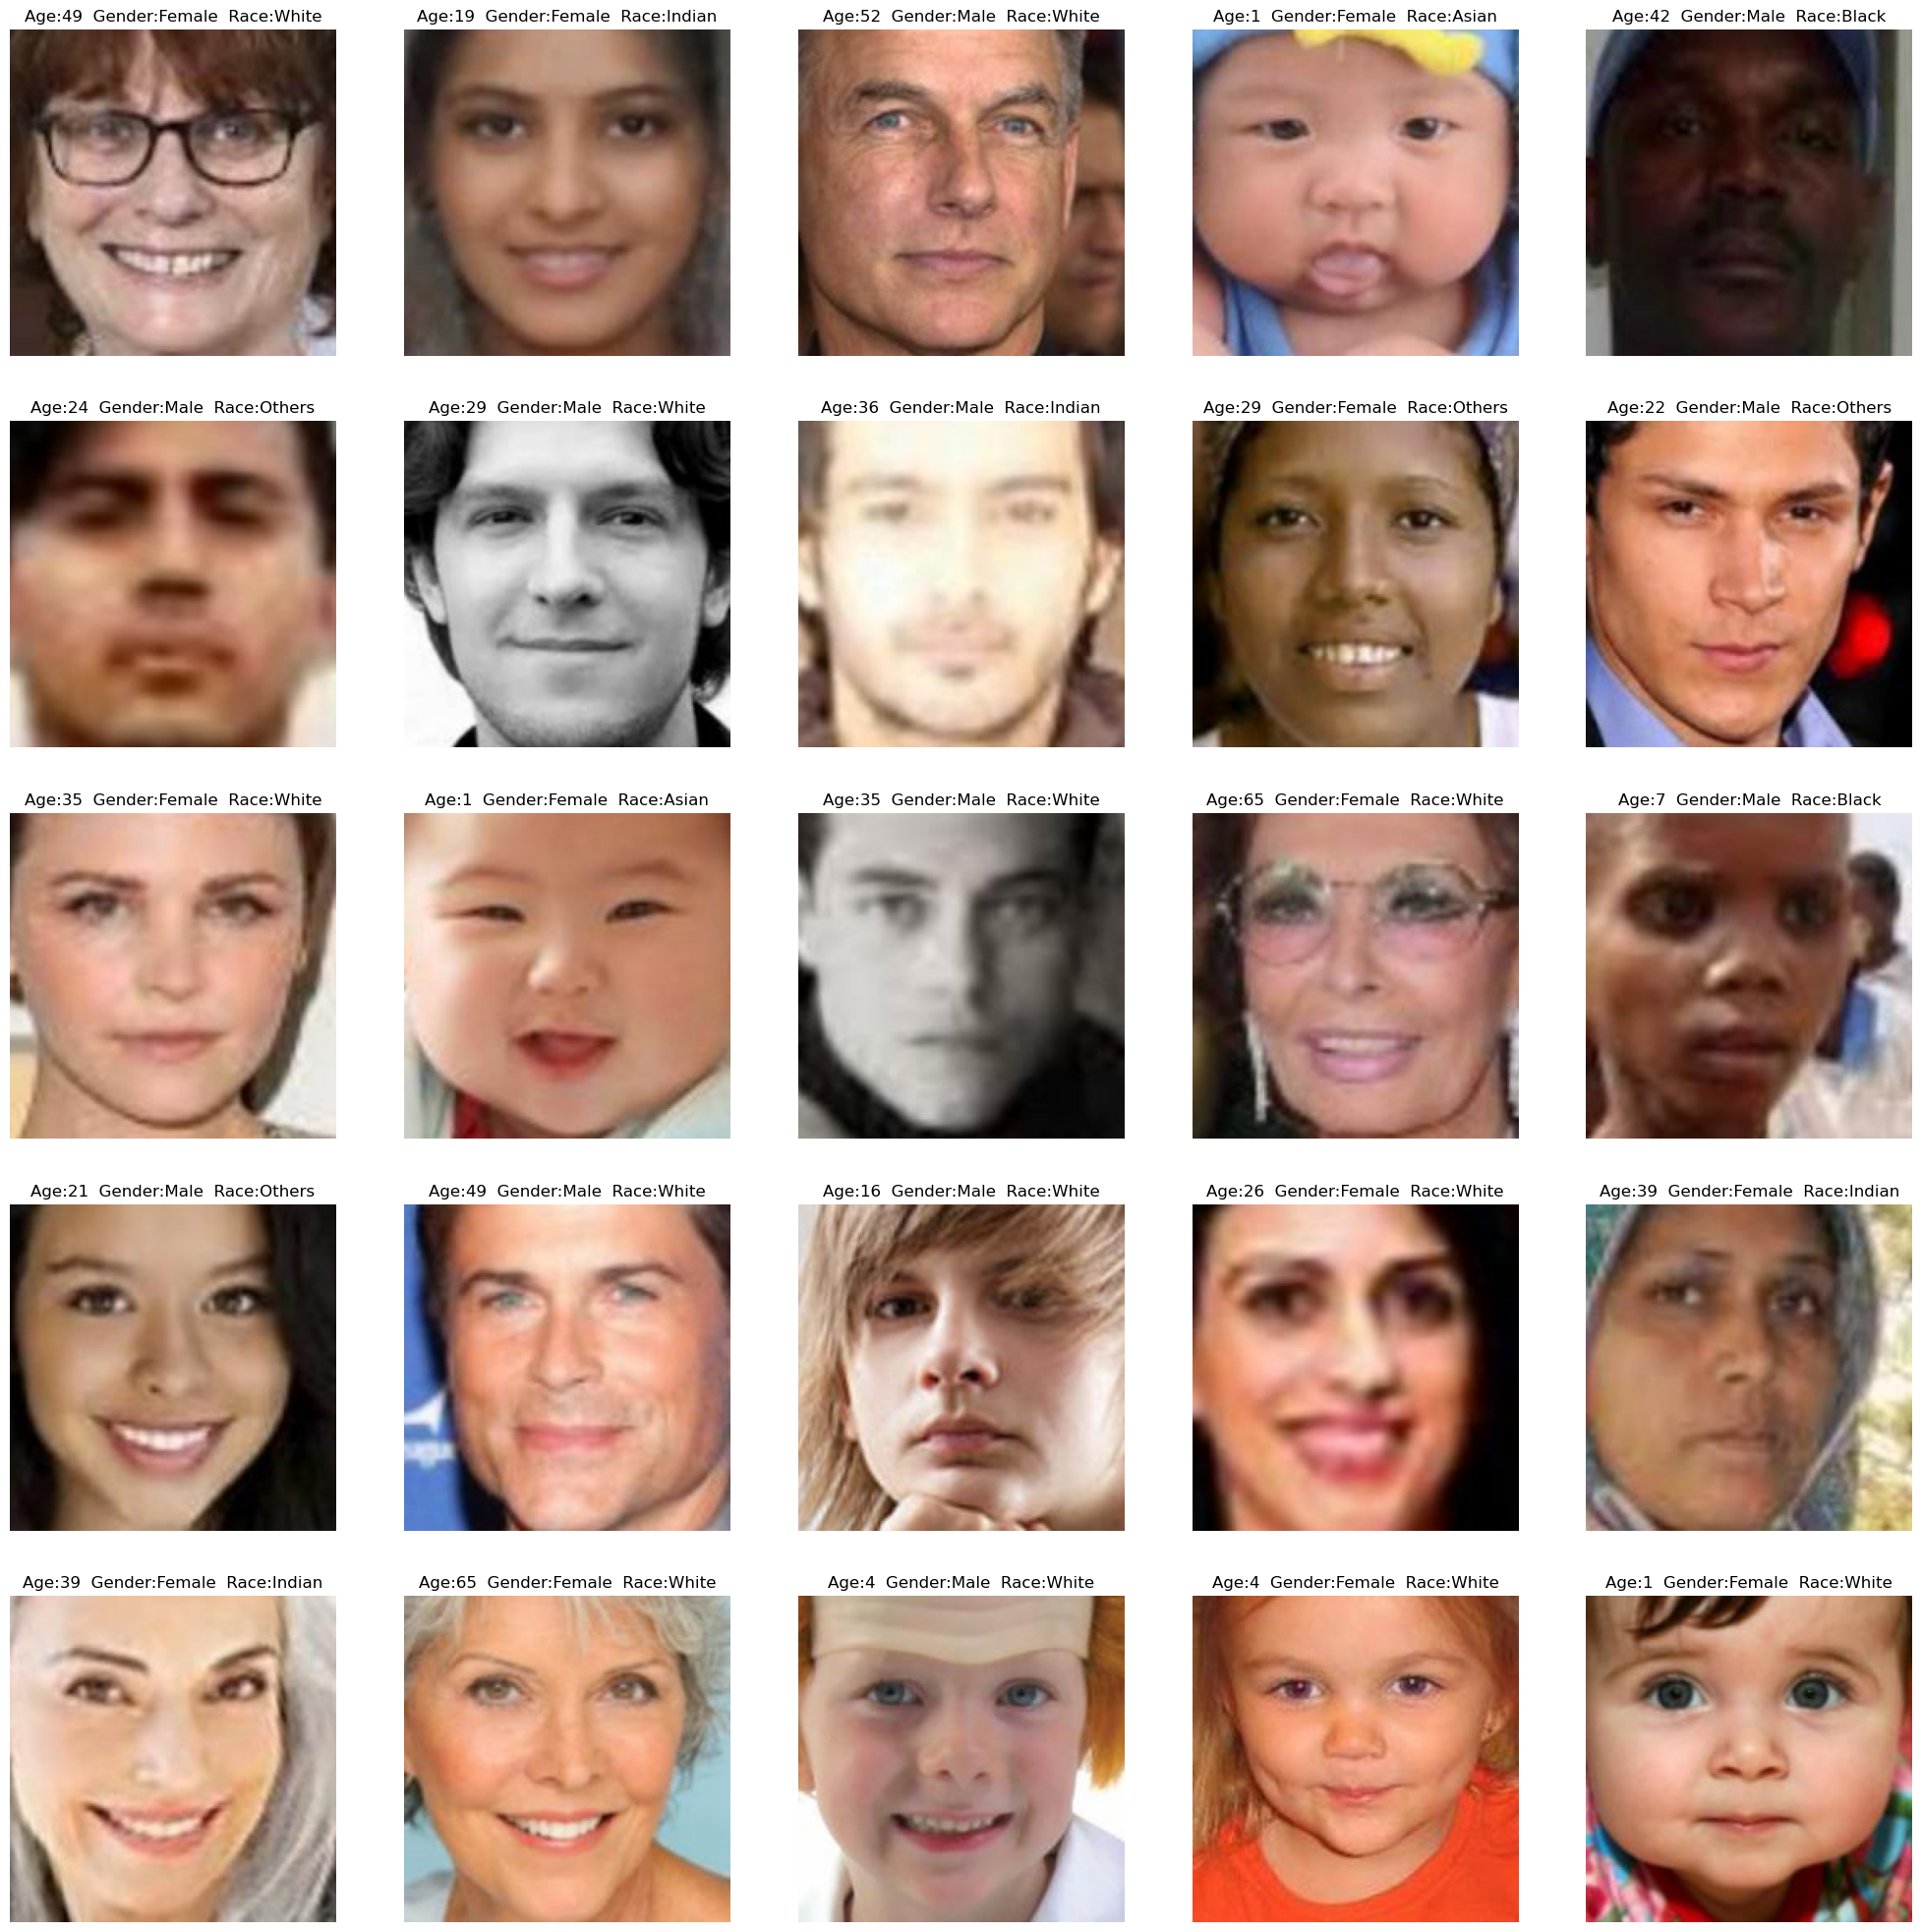

In [197]:
files = df.sample(n=25).values

plt.figure(figsize=(25,25))

for index,(image,age,gender,race) in enumerate(files):
    plt.subplot(5,5,index+1)
    img = Image.open(image)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age}  Gender:{gender_dict[gender]}  Race:{race_dict[race]}")
    plt.axis('off')

In [198]:
#HOG Function

def compute_hog_features(image_paths):
    hog_features_list = []
    
    for path in image_paths:
        image = io.imread(path, as_gray=True)
        resized_image = transform.resize(image, (64, 64))
        hog_features = hog(resized_image, orientations=9, feature_vector=True)
        
        hog_features_list.append(hog_features)
    
    return hog_features_list

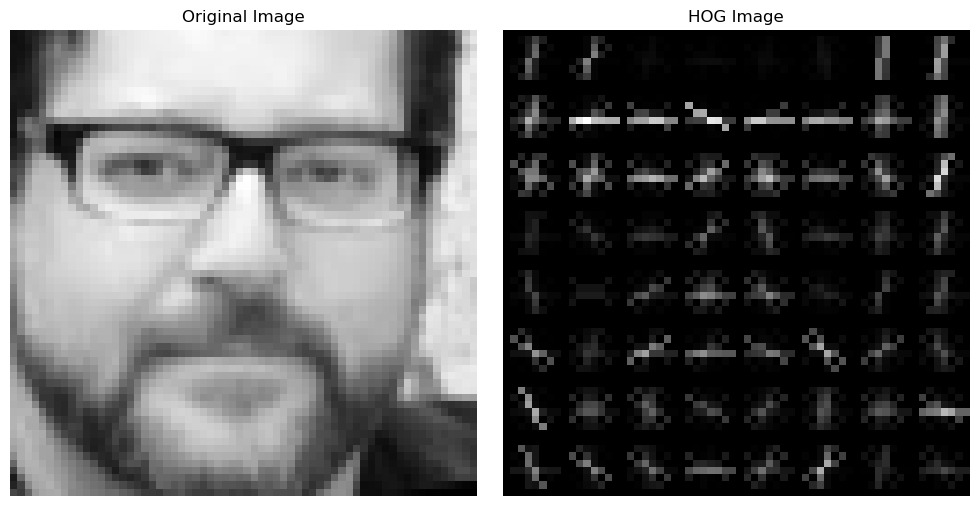

In [199]:
#Test for image

img = df.sample().values[0,0]
image = io.imread(img, as_gray=True)

resized_image = resize(image, (64, 64))

hog_features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8,8),
                              cells_per_block=(1, 1), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(resized_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(hog_image_rescaled, cmap='gray')
axes[1].set_title('HOG Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


#### Computing HOG Features

In [200]:
df['age_group'] = pd.cut(df['age'], bins=bins, labels=[1,2,3,4])

AgeClasses ={
    1: "0-17",
    2: "18-49",
    3: "50-79",
    4: "80+",
}

In [201]:
age_distribution = Counter(df['age_group'])
print("Age distribution:", age_distribution)

Age distribution: Counter({2: 10092, 1: 2701, 3: 1109, 4: 321})


In [202]:
X = compute_hog_features(df['image'])
X = np.array(X)

y = df["age_group"]

#### Splitting the data

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y ,random_state=42)

#  split the training data into validation set (fake test set)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [204]:
train_age_distribution = Counter(y_train)
print("Training set age distribution:", train_age_distribution)

test_age_distribution = Counter(y_test)
print("Testing set age distribution:", test_age_distribution)

val_age_distribution = Counter(y_val)
print("Validation set age distribution:", val_age_distribution)

Training set age distribution: Counter({2: 5650, 1: 1513, 3: 621, 4: 180})
Testing set age distribution: Counter({2: 3028, 1: 810, 3: 333, 4: 96})
Validation set age distribution: Counter({2: 1414, 1: 378, 3: 155, 4: 45})


# Models

## Logistic Regression

##  Setting Hyperparameters


we use saga or sag solver for big data 

c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


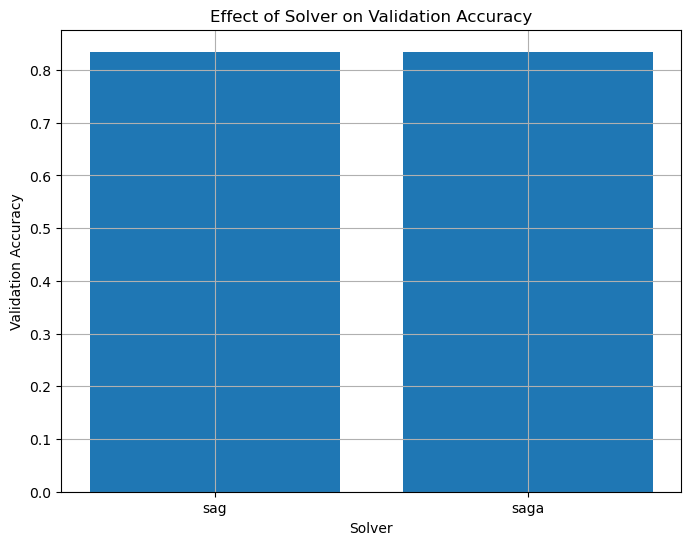

In [205]:
solvers = ['sag', 'saga']

accuracies_solver = []
for solver in solvers:
    model = LogisticRegression(solver=solver, max_iter=50)
    model.fit(X_train, y_train)
    
    predictions_val = model.predict(X_val)
    
    accuracy_val = accuracy_score(y_val, predictions_val)
    accuracies_solver.append(accuracy_val)

plt.figure(figsize=(8, 6))
plt.bar(solvers, accuracies_solver)
plt.title('Effect of Solver on Validation Accuracy')
plt.xlabel('Solver')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()


c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


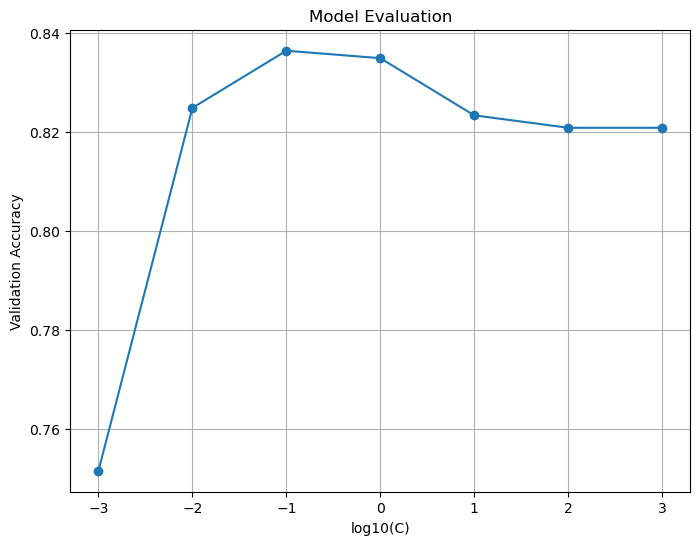

In [206]:
C_values = [0.001, 0.01, 0.1, 1, 10]

val_accuracies = []
for c in C_values:
    model = LogisticRegression(C=c, solver="saga",max_iter=50)
    model.fit(X_train, y_train)
    
    predictions_val = model.predict(X_val)
    
    accuracy_val = accuracy_score(y_val, predictions_val)
    val_accuracies.append(accuracy_val)

plt.figure(figsize=(8, 6))
plt.plot(np.log10(C_values), val_accuracies, marker='o')
plt.title('Model Evaluation')
plt.xlabel('log10(C)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\haazm\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


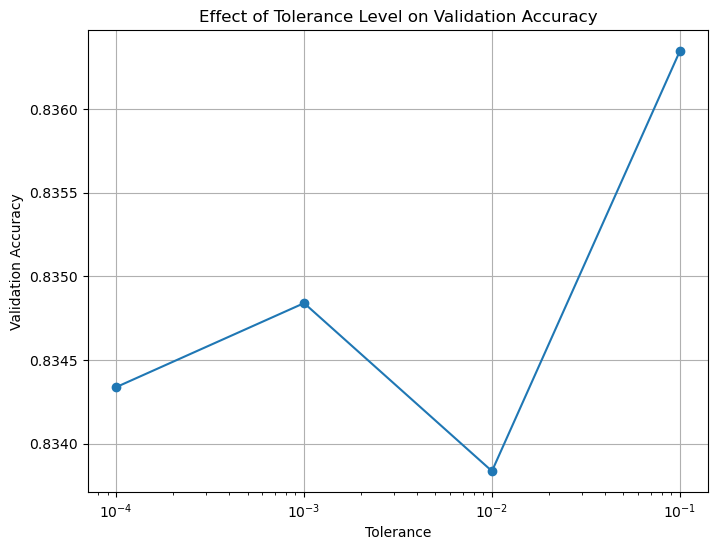

In [207]:
tolerances = [0.001, 0.01, 0.1]

accuracies_tol = []
for tol in tolerances:
    model = LogisticRegression(tol=tol, solver='saga', max_iter=50)
    model.fit(X_train, y_train)
    
    predictions_val = model.predict(X_val)
    
    accuracy_val = accuracy_score(y_val, predictions_val)
    accuracies_tol.append(accuracy_val)

plt.figure(figsize=(8, 6))
plt.plot(tolerances, accuracies_tol, marker='o')
plt.title('Effect of Tolerance Level on Validation Accuracy')
plt.xlabel('Tolerance')
plt.ylabel('Validation Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()


In [208]:
age_model = LogisticRegression(C=0.1, solver="saga", tol=0.1)
age_model.fit(X_train, y_train) 

LogisticRegression(C=0.1, solver='saga', tol=0.1)

In [209]:
accuracy = age_model.score(X_test,y_test) 
print(f"Accuracy for Age Prediction: {accuracy:.2f}")

Accuracy for Age Prediction: 0.84


In [210]:
train_predictions = age_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

# Predictions on test set
test_predictions = age_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)    


val_predictions = age_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)



print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Train Accuracy: 0.8571
Test Accuracy: 0.8437
Validation Accuracy: 0.8318


### Results

src/utkface/35_0_0_20170117134947221.jpg.chip.jpg
real age is : 35


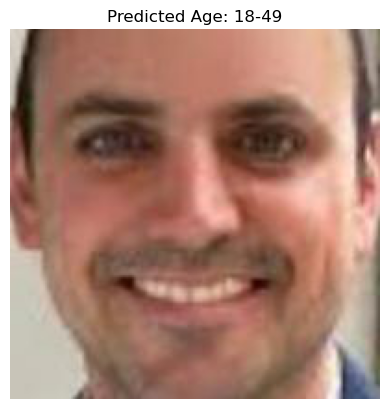

In [211]:
def compute_hog_features_single(image_path):
    image = io.imread(image_path, as_gray=True)
    resized_image = transform.resize(image, (64, 64))
    hog_features = hog(resized_image, orientations=9, feature_vector=True)
    return hog_features

random_row = df.sample().values
random_image_path = random_row[0,0]
real_age = random_row[0,1]

test_hog_feature = compute_hog_features_single(random_image_path)
random_prediction = age_model.predict([test_hog_feature])

print(random_image_path)
print(f"real age is : {real_age}")

image = io.imread(random_image_path)
plt.imshow(image, cmap='gray')
plt.title(f"Predicted Age: {AgeClasses[random_prediction[0]]}")
plt.axis('off')
plt.show()


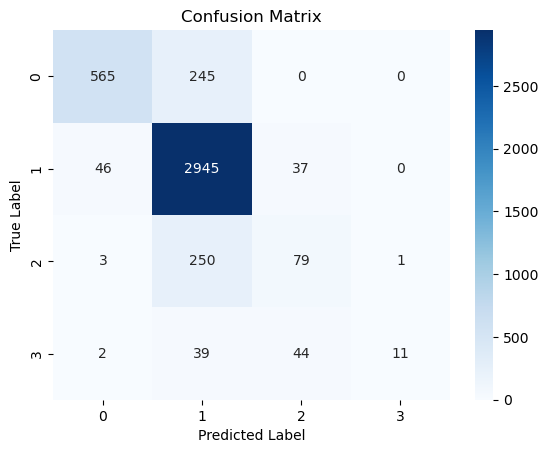

In [212]:

y_pred = age_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

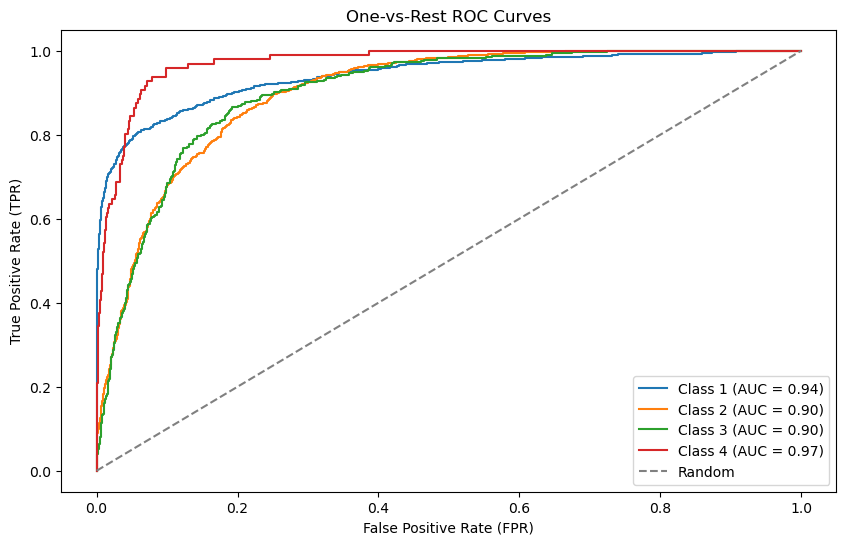

In [213]:
y_prob = age_model.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=age_model.classes_)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(age_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(age_model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('One-vs-Rest ROC Curves')
plt.legend()
plt.show()

## KMeans Clustering

In [214]:
print(X.shape)
print(X[0].shape)

(14223, 2916)
(2916,)


In [215]:
Scaler = MinMaxScaler()
X = Scaler.fit_transform(X)
X


In [216]:
print(X.shape)
print(X[0].shape)

(14223, 2916)
(2916,)


In [217]:
z = df['image'][0]

In [218]:
print(X.shape)
print(X[0].shape)


(14223, 2916)
(2916,)


In [220]:
max_clusters = 8
inertia = []
silhouette = []
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=400, random_state=42)
    kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))


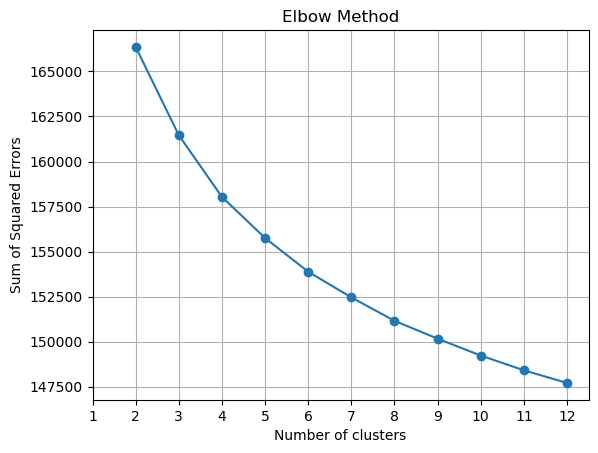

In [221]:
# plot the elbow graph with a maximum of 5 clusters
plt.plot(range(2, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

In [222]:
print(inertia)

[166358.70517079937, 161460.01508757606, 158036.33871541684, 155755.7088376002, 153884.471631535, 152460.080372829, 151160.68235720432, 150168.79939026193, 149233.44989422485, 148413.28233234872, 147712.51662263306]


ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

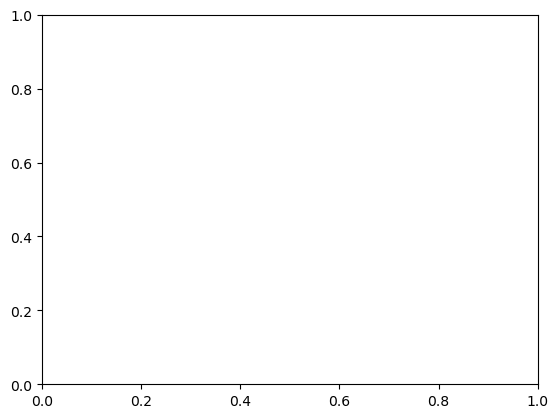

In [223]:
plt.plot(range(2, max_clusters + 1), silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.show()

In [ ]:
silhouette

[0.05118635730232818,
 0.0459401994273064,
 0.04295215224468115,
 0.043973970026311725,
 0.03687092737324983,
 0.03529607015529734,
 0.03389889935454484,
 0.031782974295355815,
 0.028856937572719947,
 0.028075671530938623,
 0.027905362291943164]

In [ ]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=400, random_state=42)

clusters = kmeans.fit_predict(X)
df['cluster'] = kmeans.labels_

In [ ]:
print(kmeans.inertia_)
print(silhouette_score(X, df['cluster']))

80714.47282842871
0.043973970026311725


### Results

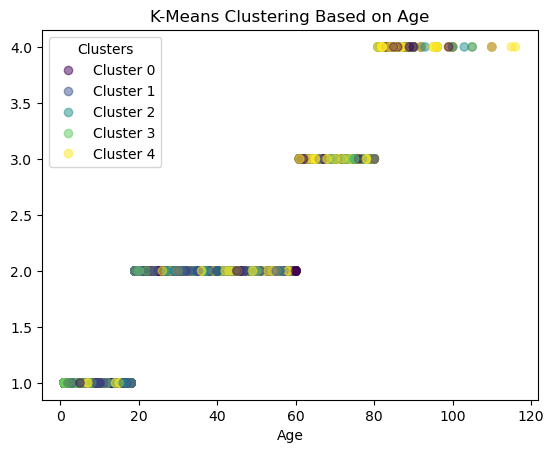

In [ ]:
scatter = plt.scatter(df['age'], df['age_group'], c=clusters, cmap='viridis', alpha=0.5)

legend_labels = [f'Cluster {i}' for i in range(clusters.size)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

plt.xlabel('Age')
plt.title('K-Means Clustering Based on Age')
plt.show()